In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import seaborn as sns

In [21]:
import random
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
plt.rc('text', usetex=True)

## Change of variables

Let $f(x): x \to y$ be an invertible map on the random variable x. In this case, let $f(x) = 2x$.
If we have a probability density $p_X(x)$, then the new probability density will be given by

$$
p_Y(y) = p_X(g^{-1} (y)) \left| \frac{d}{\,dy} g^{-1}(y) \right|
$$

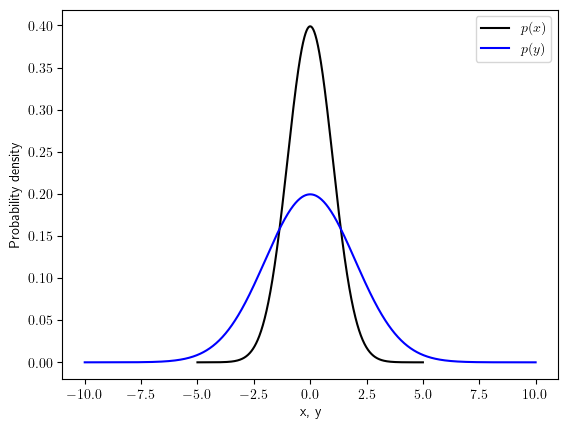

In [22]:
x_vals = np.linspace(-5, 5, 1000)
def p_x(x):
    return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
plt.plot(x_vals, p_x(x_vals), label=r'$p(x)$', color='black')

def g(x):
    return 2*x
y_vals = g(x_vals)

def g_inv(y):
    return y / 2
def d_dy_g_inv(y):
    return 1 / 2

def p_y(y):
    return p_x(g_inv(y)) * np.abs(d_dy_g_inv(y))

plt.plot(y_vals, p_y(y_vals), label=r'$p(y)$', color='blue')

plt.ylabel("Probability density")
plt.xlabel("x, y")
plt.legend()

Now, we consider the multivariable case. For $\mathbf{f}: \mathbf{X} \to \mathbf{Y}$,

\begin{align*}
p_Y(\mathbf{y}) &= p_X(\mathbf{f}^{-1}(\mathbf{y})) \left| \det \left( \frac{\partial \mathbf{f}^{-1}(\mathbf{y})}{\partial \mathbf{y}} \right) \right|
\end{align*}

In [23]:
x_1 = np.linspace(0, 10, 1000)
x_2 = np.linspace(0, 10, 1000)
X = np.array(np.meshgrid(x_1, x_2)).T.reshape(-1, 2)

We take the linear transformation
$$f: \mathbf{X} \to \mathbf{Y} = (2x_1, x_1 + x_2)$$
Since it is a linear transformation, its matrix representation is the same as its Jacobian
$$
\begin{bmatrix}
    2 & 0\\
    1 & 1
\end{bmatrix}
$$

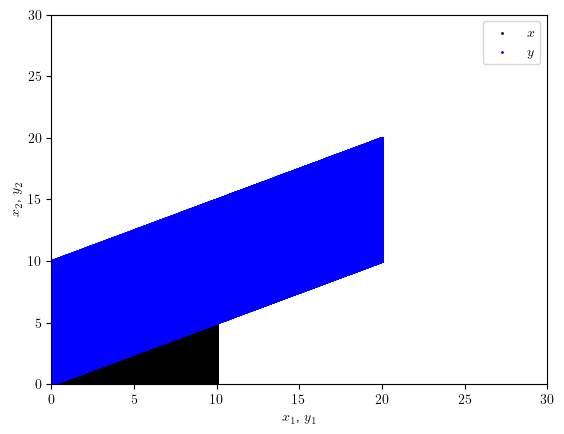

In [24]:
A = np.array([[2, 0], [1, 1]])
# def f(x):
#     return np.array([2 * x[0], x[0] + x[1]])

Y = X @ A.T
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.scatter(X[:, 0], X[:, 1], s=1, label=r'$x$', color='black')
plt.scatter(Y[:, 0], Y[:, 1], s=1, label=r'$y$', color='blue')
plt.legend()
plt.xlabel(r"$x_1$, $y_1$")
plt.ylabel(r"$x_2$, $y_2$")
plt.savefig("figs/transformation_2d.png", dpi=300, bbox_inches='tight')

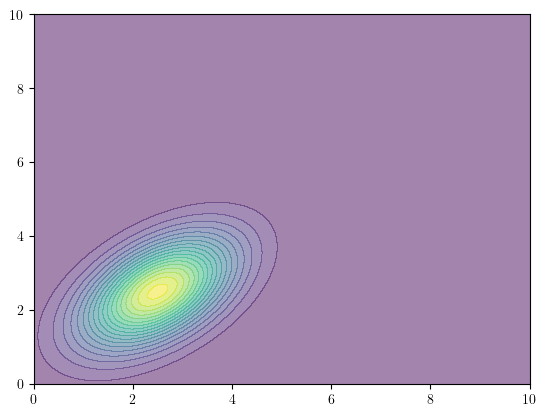

In [25]:
from scipy.stats import multivariate_normal

var_covar_mat = np.array([[1, 0.5], [0.5, 1]])
mean = np.array([2.5, 2.5])
rv = multivariate_normal(mean=mean, cov=var_covar_mat)
p_X_vals = rv.pdf(X)

plt.contourf(
    X[:, 0].reshape(1000, 1000),
    X[:, 1].reshape(1000, 1000),
    np.array(p_X_vals).reshape(1000, 1000),
    levels=20,
    # cmap='viridis',
    alpha=0.5
)

In [26]:
# Assume even spacing to find intervals
delta_x1 = x_1[1] - x_1[0]
delta_x2 = x_2[1] - x_2[0]
delta_area = delta_x1 * delta_x2
approx_integral_x = np.sum(p_X_vals) * delta_area
print(f"{approx_integral_x=:.3f}")

approx_integral_x=0.988


In [27]:
A_inv = np.linalg.inv(A)
incorrect_p_Yvals = rv.pdf(Y @ A_inv.T)
DET_F_JAC = np.linalg.det(A)
p_Y_vals = rv.pdf(Y @ A_inv.T) * DET_F_JAC

MIN_VAL = 0.01
vmin = MIN_VAL
vmax = 0.128
print(vmin, vmax)

0.01 0.128


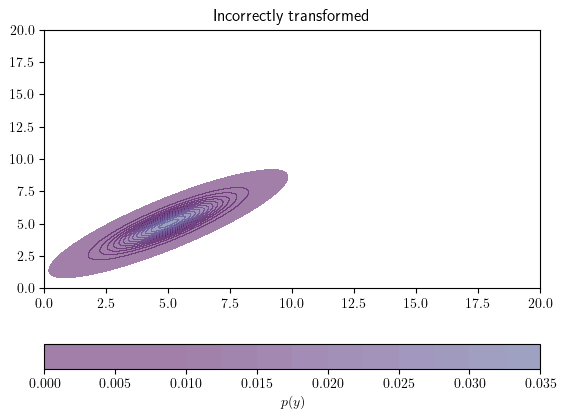

In [28]:
cf_incorrect_py = plt.contourf(
    Y[:, 0].reshape(1000, 1000),
    Y[:, 1].reshape(1000, 1000),
    np.square(
        np.ma.masked_less_equal(incorrect_p_Yvals, MIN_VAL)
    ).reshape(1000, 1000),
    levels=14,
    vmin=vmin,
    vmax=vmax,
    alpha=0.5
)
plt.colorbar(label=r'$p(y)$', location='bottom')
plt.title("Incorrectly transformed")
plt.savefig("figs/incorrect_py.png", dpi=300, bbox_inches='tight')

/var/folders/nf/5j1mvt3s2xxg28f4qcpqlhx40000gn/T/ipykernel_68571/2861292277.py:1: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(


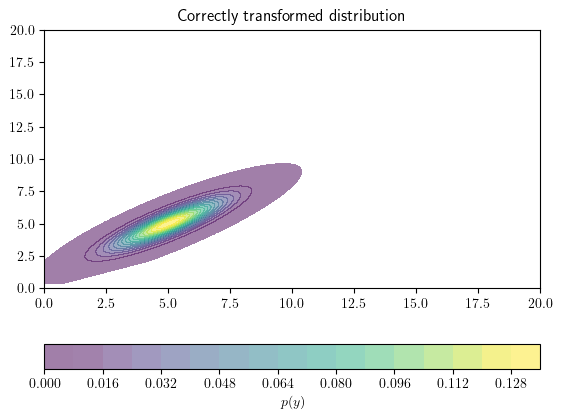

In [29]:
plt.contourf(
    Y[:, 0].reshape(1000, 1000),
    Y[:, 1].reshape(1000, 1000),
    np.square(
        np.ma.masked_less_equal(p_Y_vals, MIN_VAL)
    ).reshape(1000, 1000),
    levels=20,
    vmin=vmin,
    vmax=vmax,
    alpha=0.5,
    label=r'$p(y)$'
)
plt.colorbar(label=r'$p(y)$', location='bottom')
plt.title("Correctly transformed distribution")
plt.savefig("figs/correct_transformed_distribution.png", dpi=300, bbox_inches='tight')

## Normalizing flow model

In [30]:
import torch
from torch import nn
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


### Planar flows

We now use a Planar flow model.

A planar flow layer $f$ is defined as:
$$
f(\mathbf{z}) = \mathbf{z} + \mathbf{u} h(\mathbf{w}^T \cdot \mathbf{z} + b)
$$
where $\mathbf{u}$, $\mathbf{w}$, and $b$ are learnable parameters of the correct dimensionality.

$h$ is a pre-selected non-linear function

The Jacobian of the layer with respect to $z$ will be:
\begin{align*}
J &= \mathbf{I} + \mathbf{u}\mathbf{w^T} h'(\mathbf{w}^T \cdot \mathbf{z} + b)\\
&= \mathbf{I} +  \mathbf{u} \psi(\mathbf{z})
\end{align*}
where $\psi = h'(\mathbf{w}^T \cdot \mathbf{z} + b)\mathbf{w}$. Since this is a rank-1 update to the identity matrix, by the [matrix determinant lemma](https://mipals.github.io/pubs/matrix/matrix_determinant_lemma/), its determinant will be: $|\det (\mathbf{I} + \mathbf{u}^T \psi(\mathbf{z}))| = |1 + \mathbf{u}^T \psi(\mathbf{z})$|.

We need those so that given some $z$, we can calculate the determinant with respect to $z$. However, for the purpose of log-likelihood-based optimization, we are given an $x$ and need to find the inverse $z$. This requires us to calculate the inverse function $f^{-1}$ of the layer. We will use Newton's method to approximate the inverse.

\begin{align*}
    \mathbf{x} - \mathbf{x_0} &= f(\mathbf{z_1}) - f(\mathbf{z_0})\\
    \implies \mathbf{x} - \mathbf{x_0} &= f'(\mathbf{z_0})(\mathbf{z_1}-\mathbf{z_0})\\
    \implies \mathbf{z_1} &= (\mathbf{x}-\mathbf{x_0})(f'(\mathbf{z_0}))^{-1} + \mathbf{z_0}
\end{align*}

We already have $f'(\mathbf{z_0}) = \mathbf{I} +  \mathbf{u} \psi(\mathbf{z})$. We can find the inverse $(f'(\mathbf{z_0}))^{-1}$ by the [matrix inverse property](https://math.stackexchange.com/questions/159045/matrix-inverse-property-show-that-i-uvt-1-i-fracuvt1vtu).

$$
(f'(\mathbf{z_0}))^{-1} = \mathbf{I} - \frac{\mathbf{u} \psi(\mathbf{z_0})^T}{1 + \psi(\mathbf{z_0})^T \mathbf{u}}
$$

In [ ]:
class PlanarFlowLayer(nn.Module):
    def __init__(self, D):
        super(PlanarFlowLayer, self).__init__()
        self.dim = D
        self.u = nn.Parameter(torch.randn(D), requires_grad=True)
        self.w = nn.Parameter(torch.randn(D), requires_grad=True)
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)
        self.h = torch.tanh

    def forward(self, z):
        # z: (batch_size, dim)
        lin = torch.matmul(z, self.w) + self.b # (batch_size, )
        # u is (dim, ). 
        return z + self.u.unsqueeze(0) * self.h(lin).unsqueeze(1)
    
    def h_prime(self, z):
        """
        We hardcode the derivative of tanh
        """
        return 1 - (self.h(z)).pow(2)

    def psi(self, z):
        # z: (batch_size, dim)
        lin = torch.matmul(z, self.w) + self.b
        h_p = (self.h_prime(lin))

        #h_p: (batch_size, )
        # w: (dim, )
        # We want to return a tensor of shape (batch_size, dim)
        return h_p.unsqueeze(1) * self.w.unsqueeze(0)  # (batch_size, dim)

    def log_det_jac(self, z):
        psi_z = self.psi(z)  # (batch_size, dim)

        # inner: (batch_size, )
        inner = torch.sum(
            psi_z * self.u.unsqueeze(0), dim=1
        )
        return torch.log(torch.abs(1 + inner))

    """
    To calculate the inverse of the layer. Given some final $x$, what $z$ did we start off with
    """
    def inverse(self, x, n_iter=25):
        batch_size = x.shape[0]
        z_0 = torch.rand(batch_size, self.dim)
        for _ in range(n_iter):
            x_0 = self.forward(z_0)
            psi = self.psi(z_0)

            diff = x - x_0
            updates = torch.zeros_like(z_0)

            for b in range(batch_size):
                psi_b = psi[b]
                f_prime_inverse = torch.eye(self.dim) - (
                    torch.matmul(self.u.unsqueeze(1), psi_b.unsqueeze(0))
                    )/(1 + torch.dot(psi_b, self.u))
                updates[b] = torch.matmul(f_prime_inverse, diff[b])
            
            z_0 = z_0 + updates
        return z_0
    
class PlanarFlowModel(nn.Module):
    def __init__(self, D, num_layers=1):
        super(PlanarFlowModel, self).__init__()
        self.dim = D
        self.layers = nn.ModuleList([PlanarFlowLayer(D) for _ in range(num_layers)])
        self.base_dist = torch.distributions.Normal(0, 1)

    def forward(self, z):
        log_det_jac = 0
        for layer in self.layers:
            z = layer(z)
            log_det_jac += layer.log_det_jac(z)
        return z, log_det_jac
    
    def inverse(self, x):
        z = x
        for layer in reversed(self.layers):
            z = layer.inverse(z)
        return z
    
    def log_prob(self, x):
        z, log_det_jac = self.forward(x)
        base_log_prob = self.base_dist.log_prob(z).sum(dim=1)
        return base_log_prob + log_det_jac
    
    def sample(self, num_samples):
        z_0 = self.base_dist.sample((num_samples, self.dim)).to(device)
        x, _ = self.forward(z_0)
        return x


In [32]:
def create_target_distribution(num_samples=1000, dim=2):
    samples = []
    for _ in range(num_samples // 2):
        if torch.rand(1) < 0.5:
            sample = torch.randn(dim) * 0.5 + torch.tensor([2, 2])
        else:
            sample = torch.randn(dim) * 0.5 + torch.tensor([-2, -2])
        samples.append(sample)
    samples = torch.stack(samples).to(device)
    return samples

Text(0.5, 1.0, 'Target Distribution')

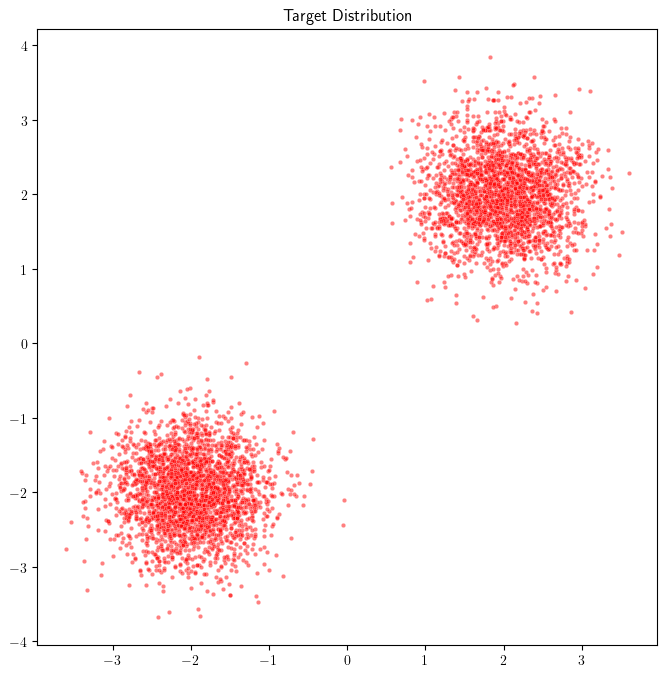

In [33]:
torch.manual_seed(RANDOM_SEED)
target_dist = create_target_distribution(num_samples=10000, dim=2)
plt.figure(figsize=(8, 8))
sns.scatterplot(x=target_dist[:, 0].cpu().numpy(), y=target_dist[:, 1].cpu().numpy(), s=10, color='red', alpha=0.5)
plt.title("Target Distribution")

In [34]:
torch.manual_seed(RANDOM_SEED)
dim = 2
n_layers = 10
model = PlanarFlowModel(dim, num_layers=n_layers)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 25_000
losses = []

best_loss = float('inf')
best_weights = None

for epoch in range(epochs):
    log_prob = model.log_prob(target_dist)
    loss = -torch.mean(log_prob)  # Minimize negative log likelihood
    losses.append(loss.item())
    
    optimizer.zero_grad()    
    loss.backward()
    optimizer.step()

    if loss.item() < best_loss:
        best_loss = loss.item()
        best_weights = {name: param.data.clone() for name, param in model.named_parameters()}
    
    if (epoch ) % 100 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}")

# restore best weights
for name, param in model.named_parameters():
    param.data = best_weights[name]
    print(f"Restored best weights for {name}")

Epoch [0/25000], Loss: 13.0919
Epoch [100/25000], Loss: 6.1885
Epoch [200/25000], Loss: 4.5117
Epoch [300/25000], Loss: 3.8722
Epoch [400/25000], Loss: 3.5307
Epoch [500/25000], Loss: 3.3178
Epoch [600/25000], Loss: 3.1637
Epoch [700/25000], Loss: 3.0404
Epoch [800/25000], Loss: 2.9392
Epoch [900/25000], Loss: 2.8584
Epoch [1000/25000], Loss: 2.7972
Epoch [1100/25000], Loss: 2.7533
Epoch [1200/25000], Loss: 2.7226
Epoch [1300/25000], Loss: 2.7009
Epoch [1400/25000], Loss: 2.6848
Epoch [1500/25000], Loss: 2.6719
Epoch [1600/25000], Loss: 2.6607
Epoch [1700/25000], Loss: 2.6501
Epoch [1800/25000], Loss: 2.6398
Epoch [1900/25000], Loss: 2.6294
Epoch [2000/25000], Loss: 2.6188
Epoch [2100/25000], Loss: 2.6083
Epoch [2200/25000], Loss: 2.5978
Epoch [2300/25000], Loss: 2.5877
Epoch [2400/25000], Loss: 2.5781
Epoch [2500/25000], Loss: 2.5690
Epoch [2600/25000], Loss: 2.5604
Epoch [2700/25000], Loss: 2.5522
Epoch [2800/25000], Loss: 2.5444
Epoch [2900/25000], Loss: 2.5368
Epoch [3000/25000], L

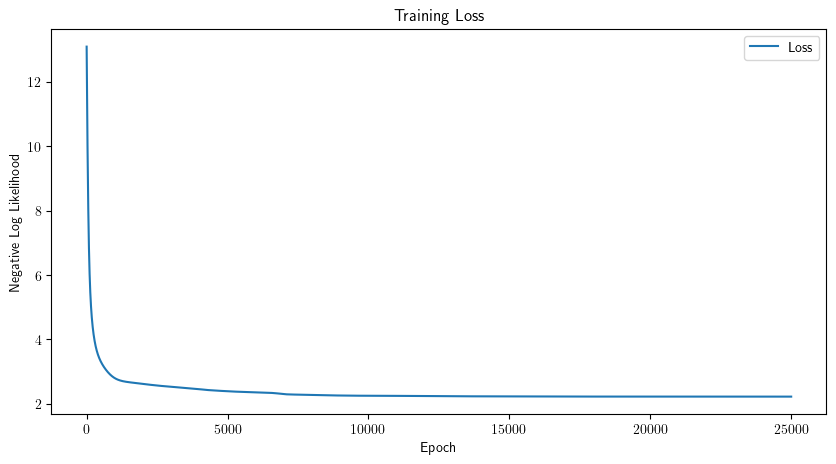

In [35]:

plt.figure(figsize=(10, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Negative Log Likelihood')
plt.title('Training Loss')
plt.legend()
plt.savefig("figs/planar_flow_training_loss.png", dpi=300, bbox_inches='tight')

In [36]:
n_viz_samples = 2000
model_samples = model.sample(n_viz_samples).detach().cpu().numpy()

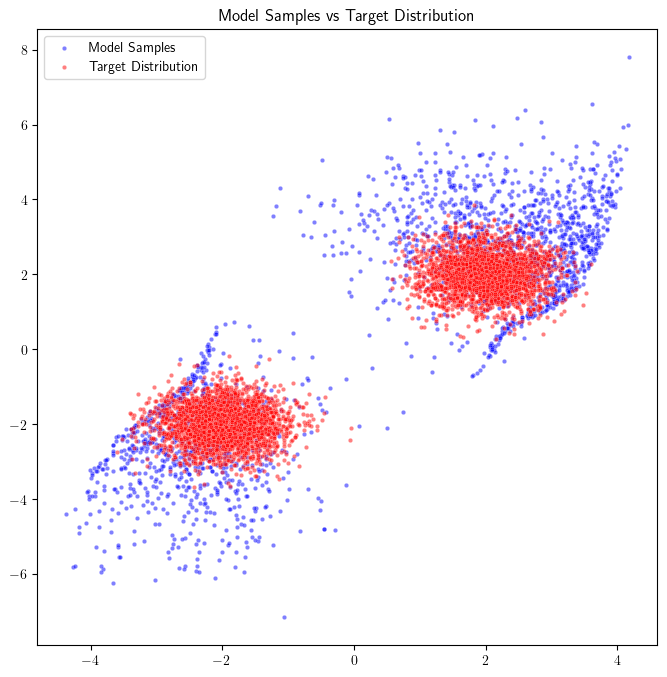

In [37]:

plt.figure(figsize=(8, 8))
sns.scatterplot(x=model_samples[:, 0], y=model_samples[:, 1], s=
10, color='blue', alpha=0.5, label='Model Samples')
sns.scatterplot(x=target_dist[:, 0].cpu().numpy(), y=target_dist[:, 1].cpu().numpy(), s=10, color='red', alpha=0.5, label='Target Distribution')
plt.title("Model Samples vs Target Distribution")
plt.legend()
plt.savefig("figs/planar_flow_samples.png", dpi=300, bbox_inches='tight')